#  Principal Component Analysis and Unsupervised Learning
## The von Karman vortex street
Author: Michelle Contreras Cossio

In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

1. Explore the included von Karman datasets using the code below. What symmetries are present in the data? Do any symmetries change as we increase the Reynolds number?

At low Reynolds number, the flow goes through the cylinder pretty smoothly. But increasing it, creates the vortices, that present symmetries, almost like a mirror. But increasing the Reynolds number the vortices become chaotic.

In [8]:
from ipywidgets import interact, interactive, fixed, interact_manual, Layout
import ipywidgets as widgets

def plotter(i):
    # plt.close()
    fig = plt.figure(figsize=(10, 10))
    vscale = np.percentile(np.abs(vort_field[i]), 98)
    plt.imshow(
        vort_field[i],
        vmin=-vscale, vmax=vscale, cmap="RdBu"
    )
    plt.show()

Re = [300,600,900,1200] # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
for element in Re:
    vfield = np.load(
        f"../../cphy/resources/vortex_street_data/vortex_street_velocities_Re_{element}_largefile.npz", 
        allow_pickle=True
    )
    print("Velocity field data has shape: {}".format(vfield.shape))

    # Calculate the vorticity, which is the curl of the velocity field
    vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0] 

    print("Reynolds number: ", element)
    ## Make an interactive video (optional; requires ipywidgets and has some RAM overhead)
    interact(
        plotter,
        i=widgets.IntSlider(0, 0, len(vort_field) - 1, 1, layout=Layout(width='500px'))
    )



Velocity field data has shape: (3000, 256, 128, 2)
Reynolds number:  300


interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=2999), Output()), …

Velocity field data has shape: (3000, 256, 128, 2)
Reynolds number:  600


interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=2999), Output()), …

Velocity field data has shape: (3000, 256, 128, 2)
Reynolds number:  900


interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=2999), Output()), …

Velocity field data has shape: (3000, 256, 128, 2)
Reynolds number:  1200


interactive(children=(IntSlider(value=0, description='i', layout=Layout(width='500px'), max=2999), Output()), …

### Implementation of Principal Component Analysis
2. Implement Principal Component Analysis in Python

In [11]:

Re = 1200 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"../../cphy/resources/vortex_street_data/vortex_street_velocities_Re_{element}_largefile.npz", 
    allow_pickle=True
)
print("Velocity field data has shape: {}".format(vfield.shape))

# Calculate the vorticity, which is the curl of the velocity field
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0] 

Velocity field data has shape: (3000, 256, 128, 2)


In [12]:
from sklearn.base import BaseEstimator, TransformerMixin

# We are going to use class inheritance to define our object. The two base classes from
# scikit-learn represent placeholder objects for working with datasets. They include 
# many generic methods, like fetching parameters, getting the data shape, etc.
# 
# By inheriting from these classes, we ensure that our object will have access to these
# functions, even though we don't have to define them ourselves
class PrincipalComponents(BaseEstimator, TransformerMixin):
    """
    A class for performing principal component analysis on a dataset.
    """

    def __init__(self, random_state=None):
        self.random_state = random_state
        self.components_ = None
        self.singular_values_ = None

        np.random.seed(self.random_state)

    def fit(self, Xr):
        """
        Fit the PCA model to the data X. Store the eigenvectors in the attribute
        self.components_ and the eigenvalues in the attribute self.singular_values_

        NOTE: This method needs to return self in order to work properly with the
         scikit-learn base classes from which it inherits.

        Args:
            Xr (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be fit.
        
        Returns:
            self (PrincipalComponents): The fitted object.
        """

        # 1. Center our data by the feature-wise mean vector
        Xr_mean = np.mean(Xr, axis=0)
        X = Xr -Xr_mean

        # 2. Compute the covariance matrix
        sigma = X.T @ X / X.shape[0]

        # 3. Compute the eigenvectors 
        eigenvalues, eigenvectors = np.linalg.eigh(sigma)
        # outputs eigenvalues in ascending order 
        # eigenvectors[:,i] is corresponding to eigenvalues[i] 

        # 4. And sort them in descending order of accompanying eigenvalue magnitude, 
        # and then stack the first  eigenvectors to create the coefficient matrix
        self.components_ = eigenvectors.T[::-1]
        self.singular_values_ = eigenvalues[::-1]

        return self

    def transform(self, Xr):
        """
        Transform the data X into the new basis using the PCA components.

        Args:
            Xr (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be transformed.

        Returns:
            X_new (np.ndarray): A 2D array of shape (n_samples, n_components) containing
                the transformed data. n_components <= n_features, depending on whether
                we truncated the eigensystem.
        """

        # Center our data by the feature-wise mean vector
        Xr_mean = np.mean(Xr, axis=0)
        X = Xr - Xr_mean 

        # Multiply by the covariant matrix:
        X_new = X @ self.components_.T 

        return X_new 

    def inverse_transform(self, X):
        """
        Transform from principal components space back to the original space

        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_components) containing the
                data to be transformed. n_components <= n_features, depending on whether
                we truncated the eigensystem.

        Returns:
            X_new (np.ndarray): A 2D array of shape (n_samples, n_features) containing
                the transformed data.
        """
        X_mean = np.mean(X, axis=0)
        X_new = X @ self.components_ + X_mean  

        return X_new

3. Plot the eigenvalues of the data covariance matrix in descending order. What does this tell us about the effective dimensionality, and thus optimal number of features, to use to represent the von Karman dataset?

Text(0, 0.5, 'Eigenvalue rank')

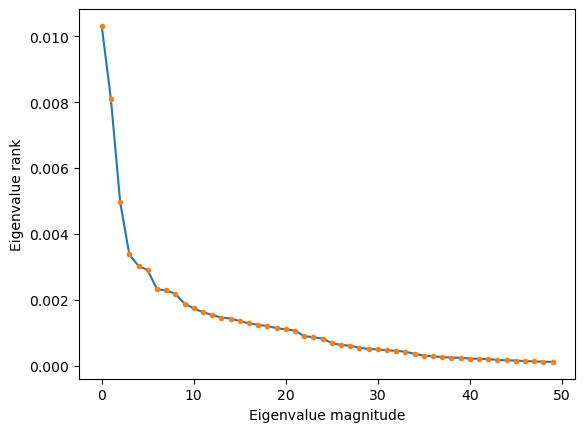

In [13]:
# Load William's solutions
#from solutions.pca import PrincipalComponents

data = np.copy(vort_field)[::3, ::2, ::2] # subsample data to reduce compute load
data_reshaped = np.reshape(data, (data.shape[0], -1))

model = PrincipalComponents()
# model = PCA()

data_transformed = model.fit_transform(data_reshaped)

principal_components = np.reshape(
    model.components_, (model.components_.shape[0], data.shape[1], data.shape[2])
)

## Look at skree plot, and identify the "elbow" indicating low dimensionality
plt.figure()
plt.plot(model.singular_values_[:50])
plt.plot(model.singular_values_[:50], '.')
plt.xlabel("Eigenvalue magnitude")
plt.ylabel("Eigenvalue rank")

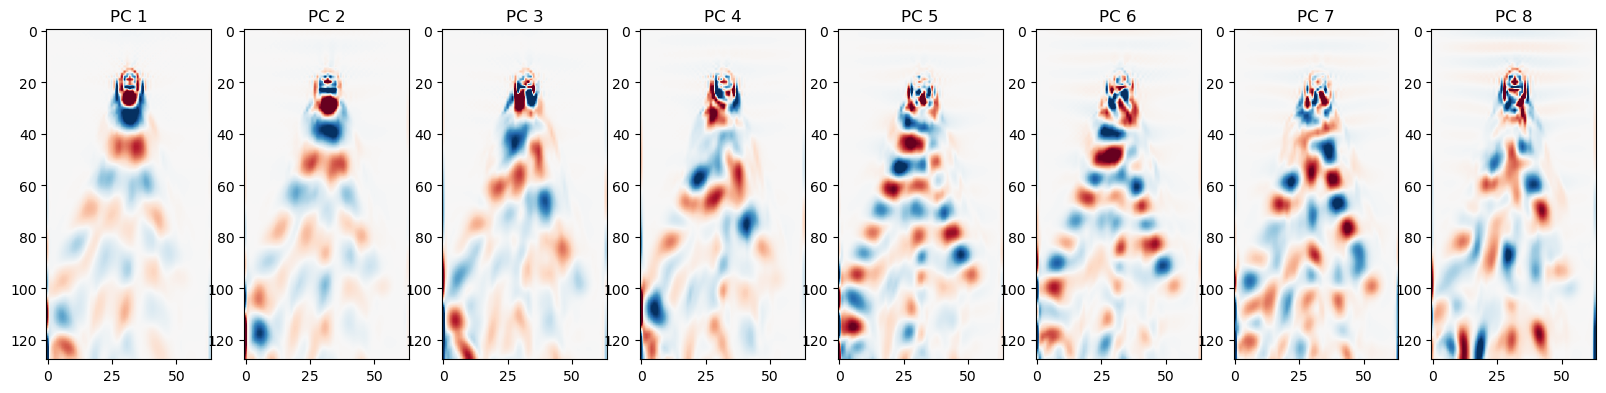

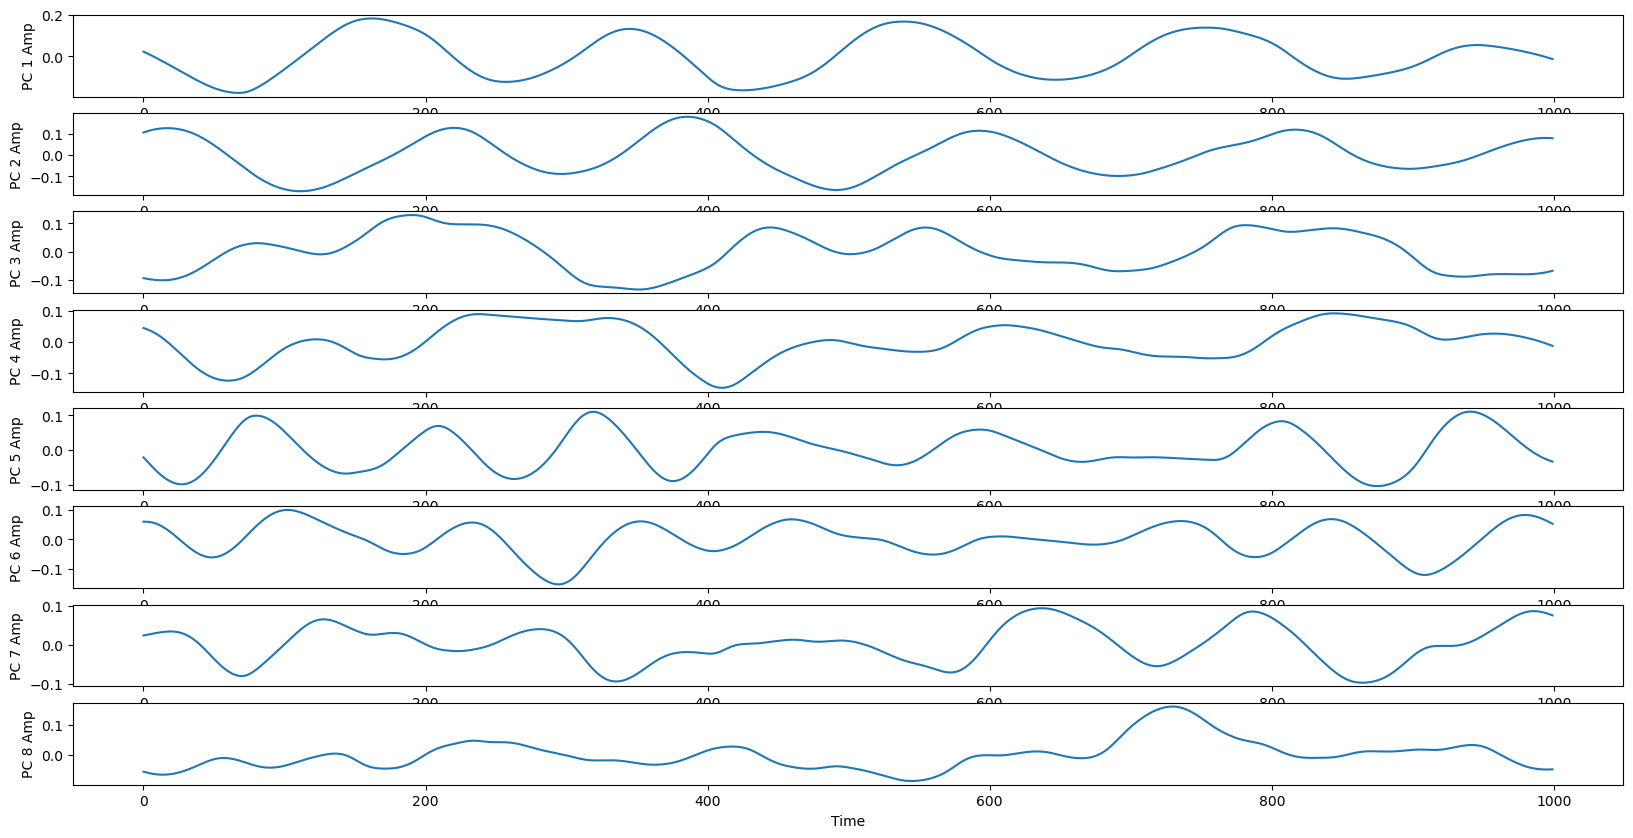

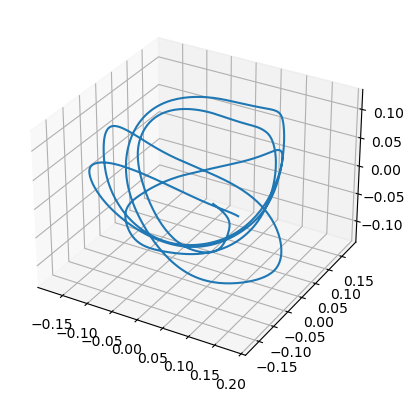

In [14]:
plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    vscale = np.percentile(np.abs(principal_components[i]), 99)
    plt.imshow(principal_components[i], cmap="RdBu", vmin=-vscale, vmax=vscale)
    plt.title("PC {}".format(i+1))

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(data_transformed[:, i])
    plt.ylabel("PC {} Amp".format(i+1))
plt.xlabel("Time")

plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data_transformed[:, 0], data_transformed[:, 1], data_transformed[:, 2])

4. Try re-running your analysis using datasets from different Reynolds numbers. How does the effective dimensionality of the problem change as Reynolds number increases? 

It also increases

Velocity field data has shape: (3000, 256, 128, 2)


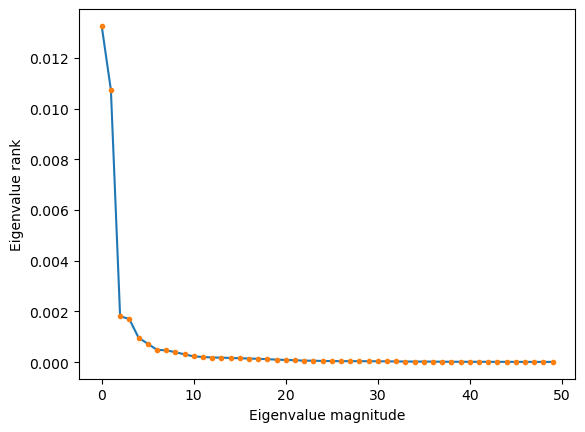

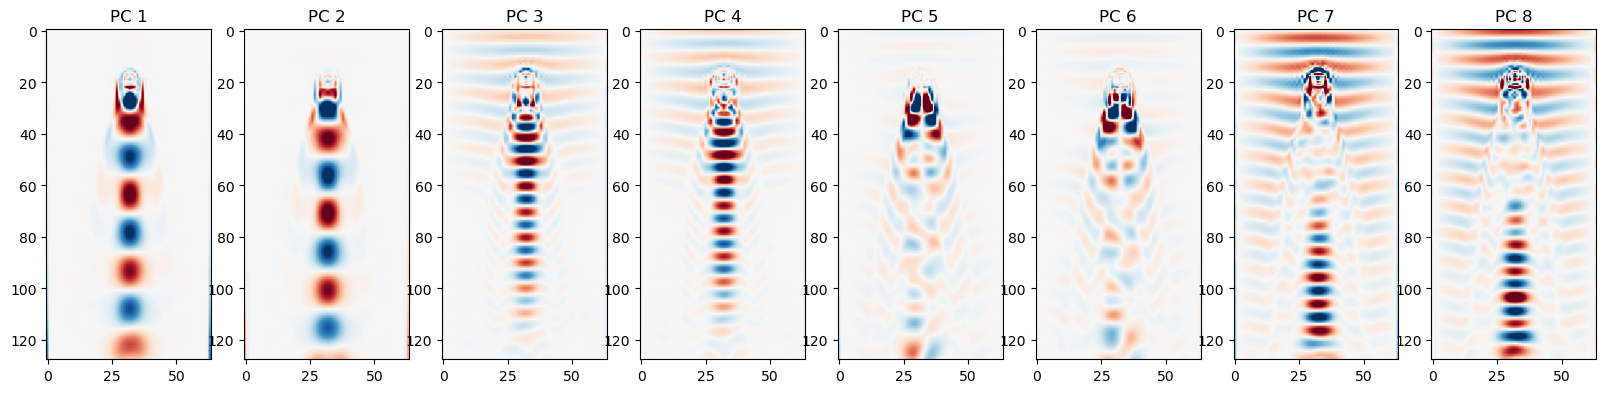

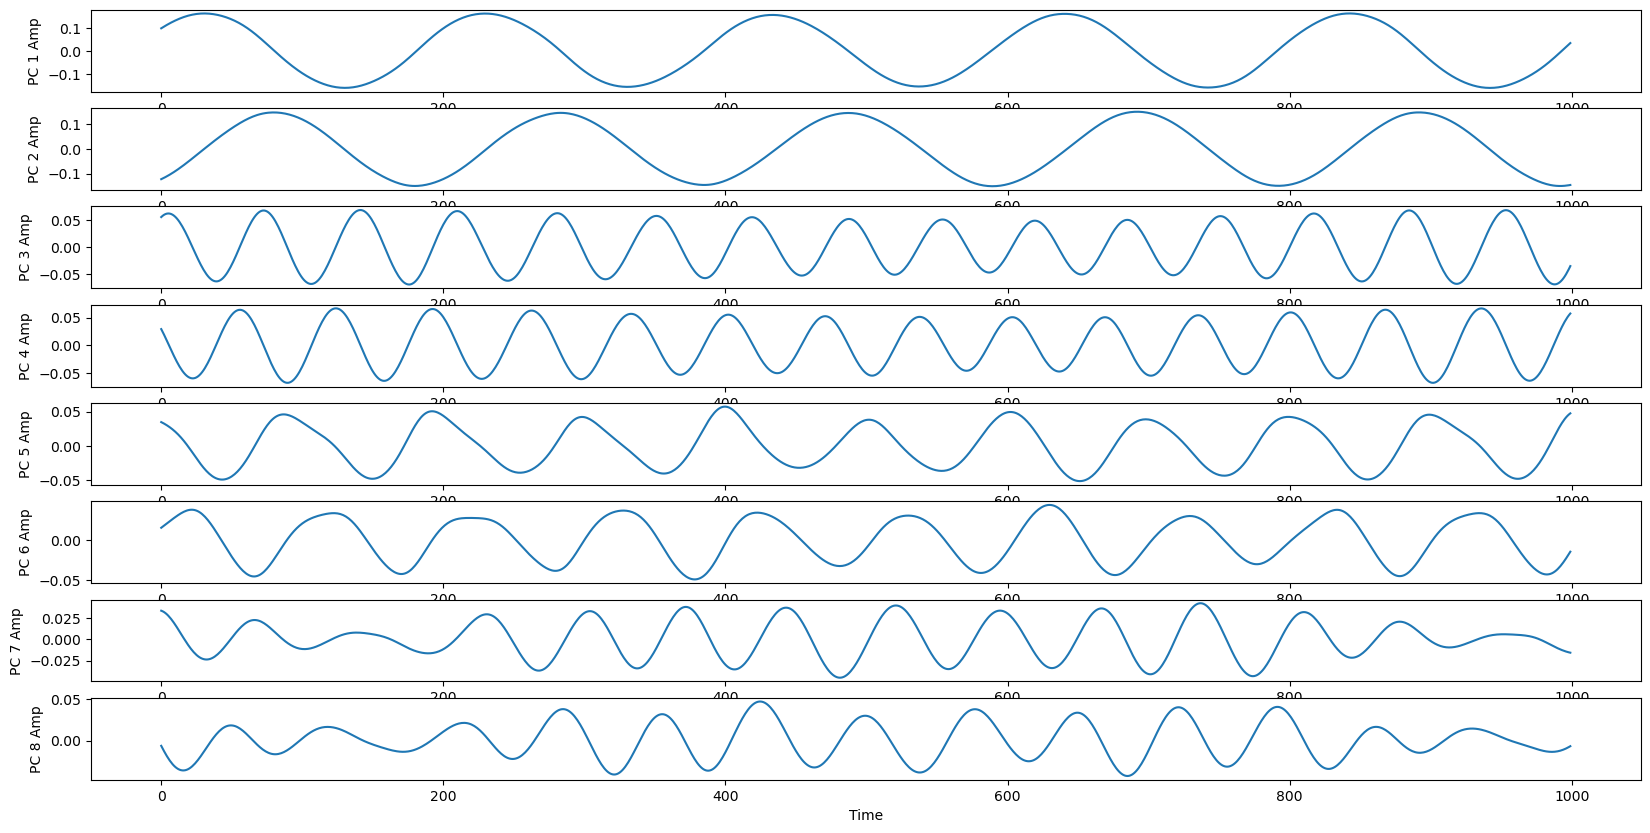

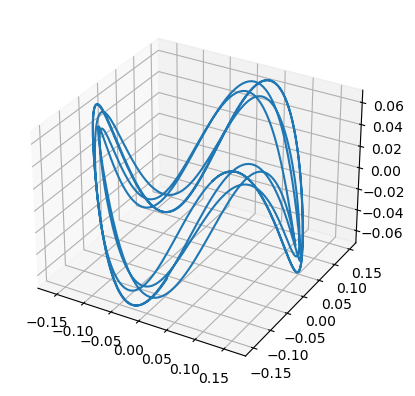

In [15]:
Re = 300 # Reynolds number, change this to 300, 600, 900, 1200

# Load the two-dimensional velocity field data. Data is stored in a 4D numpy array,
# where the first dimension is the time index, the second and third dimensions are the
# x and y coordinates, and the fourth dimension is the velocity components (ux or uv).
vfield = np.load(
    f"../../cphy/resources/vortex_street_data/vortex_street_velocities_Re_{Re}_largefile.npz", 
    allow_pickle=True
)
print("Velocity field data has shape: {}".format(vfield.shape))

# Calculate the vorticity, which is the curl of the velocity field
vort_field = np.diff(vfield, axis=1)[..., :-1, 1] + np.diff(vfield, axis=2)[:, :-1, :, 0] 

data = np.copy(vort_field)[::3, ::2, ::2] # subsample data to reduce compute load
data_reshaped = np.reshape(data, (data.shape[0], -1))

model = PrincipalComponents()
# model = PCA()

data_transformed = model.fit_transform(data_reshaped)

principal_components = np.reshape(
    model.components_, (model.components_.shape[0], data.shape[1], data.shape[2])
)

## Look at skree plot, and identify the "elbow" indicating low dimensionality
plt.figure()
plt.plot(model.singular_values_[:50])
plt.plot(model.singular_values_[:50], '.')
plt.xlabel("Eigenvalue magnitude")
plt.ylabel("Eigenvalue rank")

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    vscale = np.percentile(np.abs(principal_components[i]), 99)
    plt.imshow(principal_components[i], cmap="RdBu", vmin=-vscale, vmax=vscale)
    plt.title("PC {}".format(i+1))

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(data_transformed[:, i])
    plt.ylabel("PC {} Amp".format(i+1))
plt.xlabel("Time")

plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data_transformed[:, 0], data_transformed[:, 1], data_transformed[:, 2])

5. For this problem, the principal components often appear in pairs. Can you think of a reason for this?

Because of the symmetry of the system?

6. What happens if we don't subtract the feature-wise mean before calculating PCA?

The subtraction of feature-wise mean comes from the definition of variance, and generalizing to two variables arises the covariance. But I don't have a guess of what will actually imply in the system.

In [16]:
# CODE WITHOUT THE SUBTRACTION OF X_MEAN
from sklearn.base import BaseEstimator, TransformerMixin

# We are going to use class inheritance to define our object. The two base classes from
# scikit-learn represent placeholder objects for working with datasets. They include 
# many generic methods, like fetching parameters, getting the data shape, etc.
# 
# By inheriting from these classes, we ensure that our object will have access to these
# functions, even though we don't have to define them ourselves
class PrincipalComponents(BaseEstimator, TransformerMixin):
    """
    A class for performing principal component analysis on a dataset.
    """

    def __init__(self, random_state=None):
        self.random_state = random_state
        self.components_ = None
        self.singular_values_ = None

        np.random.seed(self.random_state)

    def fit(self, Xr):
        """
        Fit the PCA model to the data X. Store the eigenvectors in the attribute
        self.components_ and the eigenvalues in the attribute self.singular_values_

        NOTE: This method needs to return self in order to work properly with the
         scikit-learn base classes from which it inherits.

        Args:
            Xr (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be fit.
        
        Returns:
            self (PrincipalComponents): The fitted object.
        """

        # 1. Center our data by the feature-wise mean vector
        # Xr_mean = np.mean(Xr, axis=0)
        X = Xr 

        # 2. Compute the covariance matrix
        sigma = X.T @ X / X.shape[0]

        # 3. Compute the eigenvectors 
        eigenvalues, eigenvectors = np.linalg.eigh(sigma)
        # outputs eigenvalues in ascending order 
        # eigenvectors[:,i] is corresponding to eigenvalues[i] 

        # 4. And sort them in descending order of accompanying eigenvalue magnitude, 
        # and then stack the first  eigenvectors to create the coefficient matrix
        self.components_ = eigenvectors.T[::-1]
        self.singular_values_ = eigenvalues[::-1]

        return self

    def transform(self, Xr):
        """
        Transform the data X into the new basis using the PCA components.

        Args:
            Xr (np.ndarray): A 2D array of shape (n_samples, n_features) containing the
                data to be transformed.

        Returns:
            X_new (np.ndarray): A 2D array of shape (n_samples, n_components) containing
                the transformed data. n_components <= n_features, depending on whether
                we truncated the eigensystem.
        """

        # Center our data by the feature-wise mean vector
        # Xr_mean = np.mean(Xr, axis=0)
        X = Xr

        # Multiply by the covariant matrix:
        X_new = X @ self.components_.T 

        return X_new 

    def inverse_transform(self, X):
        """
        Transform from principal components space back to the original space

        Args:
            X (np.ndarray): A 2D array of shape (n_samples, n_components) containing the
                data to be transformed. n_components <= n_features, depending on whether
                we truncated the eigensystem.

        Returns:
            X_new (np.ndarray): A 2D array of shape (n_samples, n_features) containing
                the transformed data.
        """
        X_mean = np.mean(X, axis=0)
        X_new = X @ self.components_ + X_mean  

        return X_new

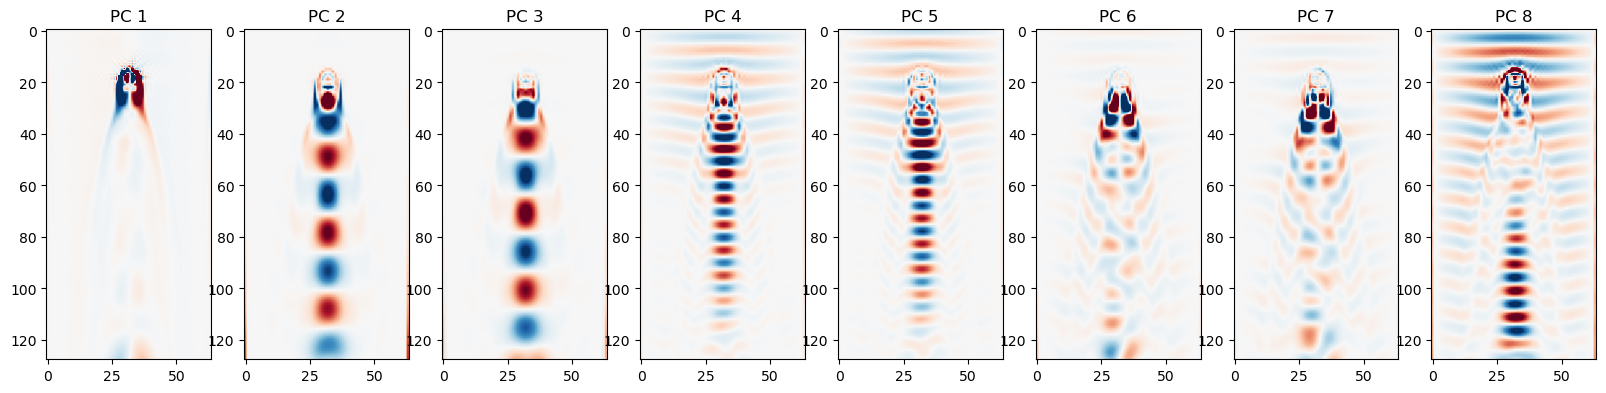

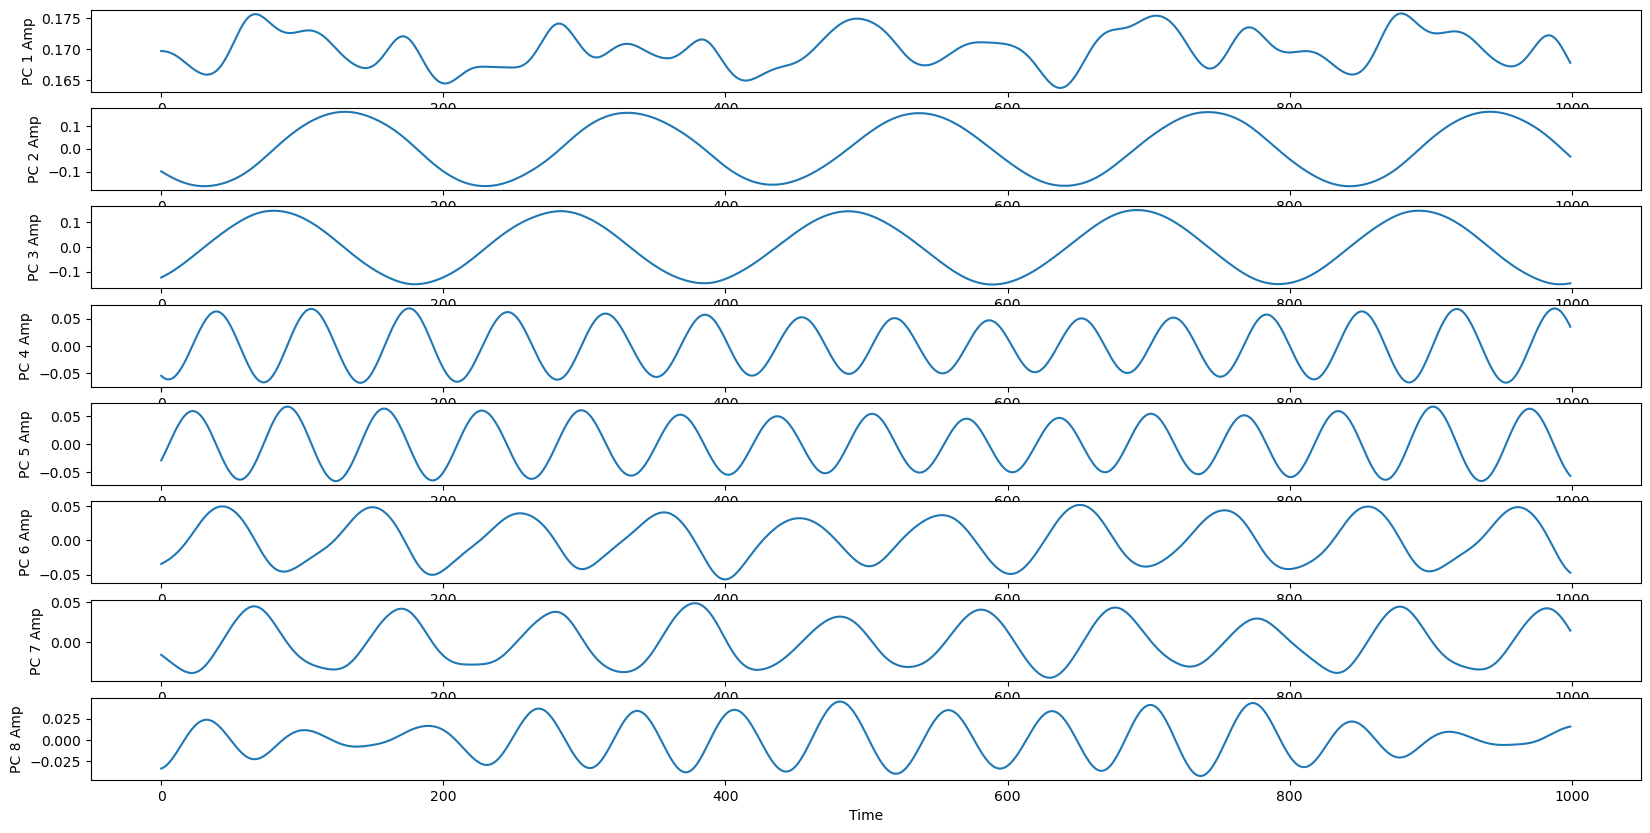

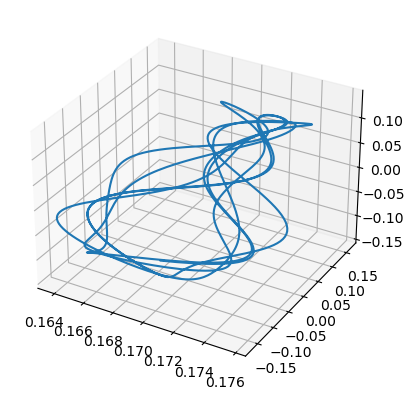

In [17]:
data = np.copy(vort_field)[::3, ::2, ::2] # subsample data to reduce compute load
data_reshaped = np.reshape(data, (data.shape[0], -1))

model = PrincipalComponents()
# model = PCA()

data_transformed = model.fit_transform(data_reshaped)

principal_components = np.reshape(
    model.components_, (model.components_.shape[0], data.shape[1], data.shape[2])
)

## Look at skree plot, and identify the "elbow" indicating low dimensionality
#plt.figure()
#plt.plot(model.singular_values_[:50])
#plt.plot(model.singular_values_[:50], '.')
#plt.xlabel("Eigenvalue magnitude")
#plt.ylabel("Eigenvalue rank")

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(1, 8, i+1)
    vscale = np.percentile(np.abs(principal_components[i]), 99)
    plt.imshow(principal_components[i], cmap="RdBu", vmin=-vscale, vmax=vscale)
    plt.title("PC {}".format(i+1))

plt.figure(figsize=(20, 10))
for i in range(8):
    plt.subplot(8, 1, i+1)
    plt.plot(data_transformed[:, i])
    plt.ylabel("PC {} Amp".format(i+1))
plt.xlabel("Time")

plt.figure()
ax = plt.axes(projection='3d')
ax.plot(data_transformed[:, 0], data_transformed[:, 1], data_transformed[:, 2])

7. In Fourier analysis, we project a function onto linear combination of trigonometric basis functions. How is this related to principal component analysis?
We are changing the basis in which we are representing the subject, and also changing the dimensions of it. 